# Cyberattack Classification Using Deep Learning

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from tensorflow.keras.layers import Dense, GRU, Dropout, BatchNormalization, Conv1D, Bidirectional
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, Dropout, BatchNormalization, Conv1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import os
from datetime import datetime
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Table of Contents
1. **Introduction**
2. **Dataset Description**
3. **Data Analysis**
4. **Problem Statement**
5. **Data Preprocessing**
   - Handling Outliers
   - Encoding Categorical Features
   - Feature Engineering
   - Balancing Classes
6. **Model Architecture**
7. **Training and Evaluation**
8. **Results**
9. **Conclusions**
- - -

## 1. Introduction

*    Cybersecurity is a critical area in today's connected world. Identifying and classifying cyberattacks using deep learning can provide a robust solution to mitigate threats efficiently.
*    This project focuses on using the **UNSW-NB15** dataset to build a deep learning model for multi-class classification of cyberattacks.
*    Due to the class imbalance, a binary classification approach is employed where each attack type is treated as a separate binary classification problem.


---

## 2. Dataset Description

*   The UNSW-NB15 dataset contains a diverse range of network attack data. It includes normal and nine types of attack categories:
    - Fuzzers
    - Analysis
    - Backdoors
    - DoS
    - Exploits
    - Generic
    - Reconnaissance
    - Shellcode
    - Worms

*   Each instance includes 49 features and labels for attack categories.
*   **Class Imbalance:** Normal traffic dominates.
*   **Mixed Feature Types:** Both numerical and categorical data.
- - -

In [19]:
class NetworkTrafficPipeline:
    def __init__(self):
        self.preprocessor = None
        self.model = None
        self.path = None
        
    def download_dataset(self):
        """Download dataset using kagglehub."""
        self.path = kagglehub.dataset_download("dhoogla/unswnb15")
        print("Dataset downloaded to:", self.path)
        return self.path
    
    def load_data(self):
        """Load training and testing datasets."""
        train_data = pd.read_parquet(f"{self.path}/UNSW_NB15_training-set.parquet")
        test_data = pd.read_parquet(f"{self.path}/UNSW_NB15_testing-set.parquet")
        return train_data, test_data

In [20]:
# Initialize pipeline
pipeline = NetworkTrafficPipeline()
    
# Download and load data
path = pipeline.download_dataset()
train_data, test_data = pipeline.load_data()

Dataset downloaded to: C:\Users\Administrator\.cache\kagglehub\datasets\dhoogla\unswnb15\versions\5


# 3. Problem Statement 

The goal is to classify network traffic as either normal or malicious, focusing on:
- Handling significant class imbalance.
- Leveraging feature engineering to improve model performance.
- Employing tailored models for each attack type.

---



# 4 Data Analysis

In [21]:
class DataAnalyzer:
    """
    A comprehensive class for exploratory data analysis and feature engineering insights.
    
    This class provides methods for:
    - Basic statistical analysis
    - Correlation detection
    - Outlier identification
    - Feature engineering suggestions and visualization
    - Data distribution analysis
    """
    
    def __init__(self, df):
        """
        Initialize the analyzer with a pandas DataFrame.
        
        Args:
            df (pd.DataFrame): Input dataset for analysis
        """
        self.df = df.copy()  # Create a copy to avoid modifying original data
        self.num_cols = self.df.select_dtypes(include=['int64', 'float64']).columns
        self.cat_cols = self.df.select_dtypes(include=['object', 'category', 'bool']).columns

    def basic_analysis(self):
        """
        Perform basic dataset analysis.
        
        Returns:
            dict: Contains missing values, numerical statistics, and categorical counts
        """
        analysis = {
            'missing_values': {
                'count': self.df.isnull().sum(),
                'percentage': (self.df.isnull().sum() / len(self.df) * 100).round(2)
            },
            'numerical_stats': self.df[self.num_cols].describe(),
            'categorical_stats': {
                col: {
                    'unique_values': self.df[col].nunique(),
                    'value_counts': self.df[col].value_counts(),
                    'missing_percentage': (self.df[col].isnull().sum() / len(self.df) * 100).round(2)
                } for col in self.cat_cols
            }
        }
        return analysis

    def identify_correlations(self, threshold=0.7):
        """
        Identify strong correlations between numerical features.
        
        Args:
            threshold (float): Correlation coefficient threshold (default: 0.7)
            
        Returns:
            pd.DataFrame: Pairs of highly correlated features
        """
        if len(self.num_cols) < 2:
            return pd.DataFrame()
            
        corr_matrix = self.df[self.num_cols].corr()
        high_corr = np.where(np.abs(corr_matrix) > threshold)
        high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                          for x, y in zip(*high_corr) if x != y and x < y]
        return pd.DataFrame(high_corr_pairs, columns=['Feature1', 'Feature2', 'Correlation'])

    def detect_outliers(self, cols=None, method='zscore', threshold=3):
        """
        Detect outliers using multiple methods.
        
        Args:
            cols (list): Specific columns to check (default: all numerical columns)
            method (str): 'zscore' or 'iqr' (default: 'zscore')
            threshold (float): Threshold for outlier detection (default: 3)
            
        Returns:
            dict: Outlier statistics for each analyzed column
        """
        if cols is None:
            cols = self.num_cols
            
        outliers = {}
        for col in cols:
            if method == 'zscore':
                z_scores = np.abs(stats.zscore(self.df[col].dropna()))
                outlier_mask = z_scores > threshold
            else:  # IQR method
                Q1 = self.df[col].quantile(0.25)
                Q3 = self.df[col].quantile(0.75)
                IQR = Q3 - Q1
                outlier_mask = ((self.df[col] < (Q1 - 1.5 * IQR)) | 
                              (self.df[col] > (Q3 + 1.5 * IQR)))
                
            outliers[col] = {
                'count': outlier_mask.sum(),
                'percentage': (outlier_mask.sum() / len(self.df[col].dropna()) * 100).round(2),
                'indexes': self.df[outlier_mask].index.tolist(),
                'range': {
                    'min': self.df[col][~outlier_mask].min(),
                    'max': self.df[col][~outlier_mask].max()
                }
            }
        return outliers

    def analyze_class_distribution(self, data, plot=True):
        """
        Analyze the distribution of classes in a dataset.
        
        Args:
            data (pd.DataFrame): Dataset 
            plot (bool): If True, display a bar plot of class distribution (default: True)
            
        Returns:
            pd.Series: Contagem de cada classe
        """
        class_distribution = data['attack_cat'].value_counts()
        
        if plot:
            plt.figure(figsize=(12, 6))
            sns.barplot(x=class_distribution.index, y=class_distribution.values)
            plt.xticks(rotation=45)
            plt.title('Attack Category Distribution')
            plt.xlabel('Attack Category')
            plt.ylabel('Count')
            plt.tight_layout()
            plt.show()
            
            # Gráfico de pizza para proporção normal vs. ataque
            plt.figure(figsize=(8, 8))
            attack_prop = data['label'].value_counts()
            plt.pie(attack_prop, labels=['Normal', 'Attack'], autopct='%1.1f%%')
            plt.title('Normal vs. Attack Traffic Distribution')
            plt.show()
        
        return class_distribution

## 4.1 Dataset Overview
The dataset contains network traffic information with both normal and malicious activities. Key characteristics include:

- Multiple features capturing network behavior
- 10 distinct classes (Normal + 9 attack categories)
- Significant class imbalance (Normal traffic dominates)
- Mix of numerical and categorical features


In [22]:
print(train_data.head())

        dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0  0.121478   tcp       -   FIN      6      4     258     172  74.087486   
1  0.649902   tcp       -   FIN     14     38     734   42014  78.473373   
2  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4  0.449454   tcp       -   FIN     10      6     534     268  33.373825   

          sload  ...  trans_depth  response_body_len  ct_src_dport_ltm  \
0  14158.942383  ...            0                  0                 1   
1   8395.112305  ...            0                  0                 1   
2   1572.271851  ...            0                  0                 1   
3   2740.178955  ...            0                  0                 1   
4   8561.499023  ...            0                  0                 2   

   ct_dst_sport_ltm  is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  \
0                 1            

In [23]:
DataAnalyzer(train_data).basic_analysis()

{'missing_values': {'count': dur                  0
  proto                0
  service              0
  state                0
  spkts                0
  dpkts                0
  sbytes               0
  dbytes               0
  rate                 0
  sload                0
  dload                0
  sloss                0
  dloss                0
  sinpkt               0
  dinpkt               0
  sjit                 0
  djit                 0
  swin                 0
  stcpb                0
  dtcpb                0
  dwin                 0
  tcprtt               0
  synack               0
  ackdat               0
  smean                0
  dmean                0
  trans_depth          0
  response_body_len    0
  ct_src_dport_ltm     0
  ct_dst_sport_ltm     0
  is_ftp_login         0
  ct_ftp_cmd           0
  ct_flw_http_mthd     0
  is_sm_ips_ports      0
  attack_cat           0
  label                0
  dtype: int64,
  'percentage': dur                  0.0
  proto         

In [24]:
DataAnalyzer(train_data).detect_outliers()

{'stcpb': {'count': 0,
  'percentage': 0.0,
  'indexes': [],
  'range': {'min': 0, 'max': 4294958913}},
 'dtcpb': {'count': 0,
  'percentage': 0.0,
  'indexes': [],
  'range': {'min': 0, 'max': 4294881924}}}

## 4.2 Class Distribution
Analysis of attack categories shows:
- Normal traffic: ~90,000 instances
- Generic attacks: ~58,000 instances
- Exploits: ~44,000 instances
- Fuzzers: ~24,000 instances
- DoS: ~16,000 instances
- Reconnaissance: ~13,000 instances
- Analysis: ~2,000 instances
- Backdoor: ~2,000 instances
- Shellcode: ~1,500 instances
- Worms: ~130 instances

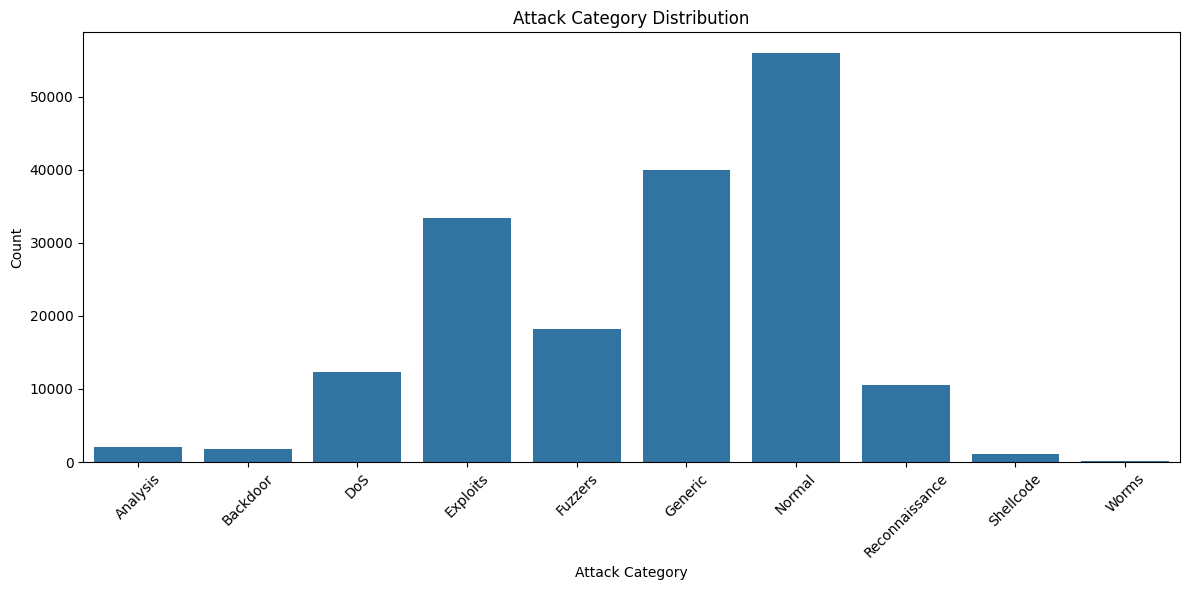

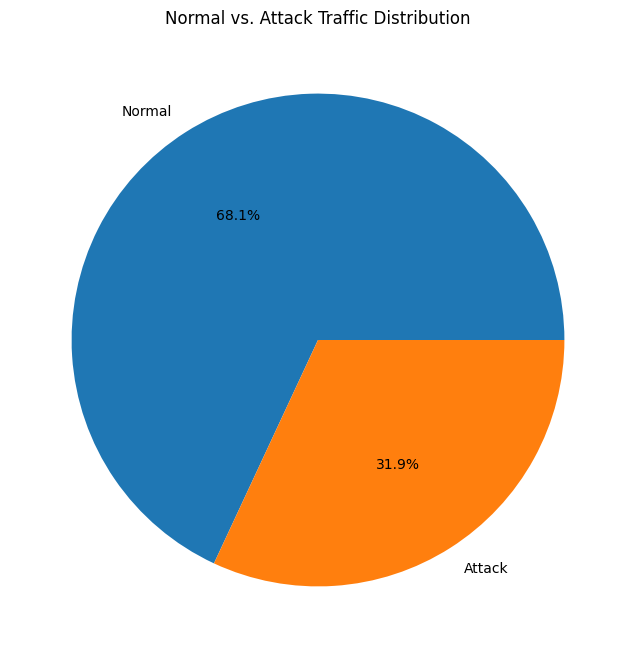

attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64

In [25]:
DataAnalyzer(train_data).analyze_class_distribution(train_data)

# 5. Data Preprocessing

### 5.1 Handling Outliers
Outliers in numerical features are addressed using the interquartile range (IQR) method to ensure robustness. The method identifies and clips extreme values in numerical columns to mitigate their impact on the models.

### 5.2 Encoding Categorical Features
Categorical columns such as `proto`, `service`, and `state` are transformed into numerical representations using label encoding. This encoding ensures that the data can be processed by machine learning algorithms without introducing unintended relationships between categories.

### 5.3 Feature Engineering
Feature engineering is a critical step to enhance the dataset's predictive power. The following engineered features are added:
- **Bytes per Packet:** Calculated as `sbytes / (spkts + 1e-8)` to represent average packet size for sent data.
- **Packet Size Ratio:** Ratio of sent to received bytes, indicating communication balance.
- **Bytes per Second:** Captures the data transmission rate over the duration of communication.
- **Packets per Second:** Measures the frequency of packet transmission.
- **Rates:** Includes features such as `srate` (sent packets per second) and `drate` (received packets per second).
- **Statistical Features:** Includes log-transformed differences between sent and received bytes/packets for numerical stability.
- **Load-Based Features:** Estimates the data load sent (`sload`) and received (`dload`) by combining rates and durations.

These features aim to capture nuanced network behavior, essential for distinguishing attack types.

### 5.4 Balancing Classes
Class imbalance is tackled using a combination of techniques:
- **Isolation Forest:** Removes noisy majority-class samples by detecting outliers, improving dataset quality.
- **Tomek Links:** Eliminates overlapping samples between classes, enhancing decision boundaries.
- **SMOTE/ADASYN:** Synthesizes new minority-class samples when the ratio is below 40%, ensuring the classifier receives sufficient examples for training. The fallback to ADASYN occurs when SMOTE fails due to insufficient neighbors in the minority class.


The `MultiClassPreprocessor` class handles all preprocessing tasks for the dataset. Key components include:
- **Initialization:** Defines label encoders for categorical features, scalers for numerical data, and feature selectors for dimensionality reduction.
- **Fitting:** Determines attack types, initializes preprocessing tools per attack type, and fits encoders on categorical features.
- **Feature Engineering:** Adds custom features to highlight traffic behavior.
- **Outlier Handling:** Applies IQR-based clipping to numerical features to standardize data ranges.
- **Binary Dataset Creation:** Prepares individual datasets for each attack type with selected and scaled features.
- **Dataset Balancing:** Balances datasets using a combination of Isolation Forest, Tomek Links, and oversampling techniques.


In [26]:
class MultiClassPreprocessor:
    """
    Handles preprocessing for multiple binary classification models,
    where each model focuses on detecting a specific type of attack.
    """
    def __init__(self):
        self.label_encoder = {}
        self.scalers = {}
        self.feature_selectors = {}
        self.categorical_columns = ['proto', 'service', 'state']
        self.columns_to_drop = ['swin', 'stcpb', 'dtcpb', 'dwin', 'is_sm_ips_ports', 'ct_flw_http_mthd']
        self.attack_types = None
        self.selected_features = {}
        
    def fit(self, data, target_column='attack_cat'):
        """
        Fit preprocessor on training data
        """
        self.attack_types = sorted(list(set(data[target_column])))
        print(f"Detected attack types: {self.attack_types}")
        
        # Initialize scalers and feature selectors for each attack type
        for attack in self.attack_types:
            if attack.lower() != 'normal':
                self.scalers[attack] = RobustScaler()
                self.feature_selectors[attack] = SelectKBest(score_func=mutual_info_classif, k=24)
        
        # Fit label encoders for categorical columns
        for col in self.categorical_columns:
            self.label_encoder[col] = LabelEncoder()
            self.label_encoder[col].fit(data[col])
            
        return self

    def _add_engineered_features(self, data):
        """Add engineered features to improve model performance"""
        feature_data = data.copy()
        
        # Packet-based features
        feature_data['bytes_per_packet'] = feature_data['sbytes'] / (feature_data['spkts'] + 1e-8)
        feature_data['packet_size_ratio'] = (feature_data['sbytes'] + 1e-8) / (feature_data['dbytes'] + 1e-8)
        
        # Time-based features
        feature_data['bytes_per_second'] = (feature_data['sbytes'] + feature_data['dbytes']) / (feature_data['dur'] + 1e-8)
        feature_data['packets_per_second'] = (feature_data['spkts'] + feature_data['dpkts']) / (feature_data['dur'] + 1e-8)
        
        # Rate-based features
        feature_data['srate'] = feature_data['spkts'] / (feature_data['dur'] + 1e-8)
        feature_data['drate'] = feature_data['dpkts'] / (feature_data['dur'] + 1e-8)
        
        # Statistical features
        feature_data['byte_ratio'] = np.log1p(feature_data['sbytes']) - np.log1p(feature_data['dbytes'])
        feature_data['packet_ratio'] = np.log1p(feature_data['spkts']) - np.log1p(feature_data['dpkts'])
        
        # Load-based features
        feature_data['sload'] = (feature_data['sbytes'] * feature_data['srate']) / (1e-8 + feature_data['dur'])
        feature_data['dload'] = (feature_data['dbytes'] * feature_data['drate']) / (1e-8 + feature_data['dur'])
        
        return feature_data

    def _handle_outliers(self, data, columns):
        """Handle outliers using IQR method"""
        clean_data = data.copy()
        for column in columns:
            Q1 = clean_data[column].quantile(0.25)
            Q3 = clean_data[column].quantile(0.75)
            IQR = Q3 - Q1
            clean_data[column] = clean_data[column].clip(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
        return clean_data

    def _create_binary_dataset(self, data, attack_type, is_training=True):
        """
        Create a binary classification dataset for a specific attack type
        """
        # Create binary labels
        binary_labels = (data['attack_cat'] == attack_type).astype(int)
    
        # Get features
        features = data.drop(['attack_cat', 'label'], axis=1)
    
        if is_training:
            # Select features
            self.feature_selectors[attack_type].fit(features.values, binary_labels.values)
            selected_features = features.columns[self.feature_selectors[attack_type].get_support()].tolist()
            self.selected_features[attack_type] = selected_features
        
            # Scale features
            self.scalers[attack_type].fit(features[selected_features].values)
    
        # Transform features
        selected_features = self.selected_features[attack_type]
        scaled_features = self.scalers[attack_type].transform(features[selected_features].values)
        scaled_features = pd.DataFrame(
            scaled_features, 
            columns=selected_features,
            index=features.index
        )
    
        # Ensure binary_labels has the same index as scaled_features
        binary_labels = pd.Series(
            binary_labels.values,
            index=scaled_features.index,
            name='label'
        )
    
        return scaled_features, binary_labels

    def _balance_dataset(self, X, y, attack_type):
        """
        Advanced dataset balancing strategy for binary classification
        """
        print(f"\nBalancing dataset for {attack_type}")
        original_shape = X.shape

        # Clean majority class using Isolation Forest
        majority_mask = y == 0
        if majority_mask.sum() > 0:
            iso_forest = IsolationForest(contamination=0.1, random_state=42)
            majority_predictions = iso_forest.fit_predict(X[majority_mask])
            clean_majority_mask = majority_mask.copy()
            clean_majority_mask[majority_mask] = majority_predictions == 1

            X = X[clean_majority_mask | ~majority_mask]
            y = y[clean_majority_mask | ~majority_mask]

        # Reindex após filtragem
        X.reset_index(drop=True, inplace=True)
        y.reset_index(drop=True, inplace=True)

        # Aplicar TomekLinks
        tomek = TomekLinks(sampling_strategy='majority')
        X_cleaned, y_cleaned = tomek.fit_resample(X, y)

        # Aplicar SMOTE se necessário
        if (y_cleaned == 1).sum() / len(y_cleaned) < 0.4:
            try:
                smote = SMOTE(
                    sampling_strategy=0.4,
                    k_neighbors=min(5, (y_cleaned == 1).sum() - 1),
                    random_state=42
                )
                X_balanced, y_balanced = smote.fit_resample(X_cleaned, y_cleaned)
            except ValueError:
                print(f"SMOTE failed for {attack_type}, using ADASYN instead")
                adasyn = ADASYN(
                    sampling_strategy=0.4,
                    n_neighbors=min(5, (y_cleaned == 1).sum() - 1),
                    random_state=42
                )
                X_balanced, y_balanced = adasyn.fit_resample(X_cleaned, y_cleaned)
        else:
            X_balanced, y_balanced = X_cleaned, y_cleaned

        print(f"Original shape: {original_shape}")
        print(f"Balanced shape: {X_balanced.shape}")
        print(f"Class distribution: 0={sum(y_balanced==0)}, 1={sum(y_balanced==1)}")

        return X_balanced, y_balanced


    def _handle_unknown_labels(self, data, col):
        """
        Handles unknown labels by assigning them a default value (-1)
        """
        encoded_column = []
        for value in data[col]:
            if value in self.label_encoder[col].classes_:
                encoded_column.append(self.label_encoder[col].transform([value])[0])
            else:
                # Append -1 for unknown values
                encoded_column.append(-1)
        return np.array(encoded_column)

    def prepare_datasets(self, data, is_training=True):
        """
        Prepare binary classification datasets for each attack type
        """
        # Basic preprocessing
        processed_data = data.copy()
        processed_data.drop(columns=self.columns_to_drop, errors='ignore', inplace=True)
        
        # Add engineered features
        processed_data = self._add_engineered_features(processed_data)
        
        # Handle categorical features
        for col in self.categorical_columns:
            # Expand LabelEncoder classes to include unknown values if necessary
            self.label_encoder[col].classes_ = np.append(self.label_encoder[col].classes_, 'unknown')
            processed_data[col] = processed_data[col].apply(
                lambda x: x if x in self.label_encoder[col].classes_ else 'unknown'
            )
            processed_data[col] = self.label_encoder[col].transform(processed_data[col])
        
        # Handle numerical features
        numerical_columns = processed_data.select_dtypes(include=['float64', 'int64']).columns
        processed_data = self._handle_outliers(processed_data, numerical_columns)
        
        # Create datasets for each attack type
        datasets = {}
        for attack_type in self.attack_types:
            if attack_type.lower() != 'normal':
                X, y = self._create_binary_dataset(processed_data, attack_type, is_training)
                
                if is_training:
                    X, y = self._balance_dataset(X, y, attack_type)
                
                datasets[attack_type] = {
                    'features': X,
                    'labels': y
                }
        
        return datasets

The `BinaryAttackDataManager` class manages data splitting and orchestrates the preprocessing workflow:
- **Data Splitting:** Divides the dataset into training, validation, and test sets, preserving class distribution.
- **Dataset Preparation:** Fits the preprocessor on the training set and applies transformations to all splits, ensuring consistent preprocessing.


In [27]:
class BinaryAttackDataManager:
    """
    Manages data preparation and preprocessing for multiple binary attack classifiers
    """
    def __init__(self):
        self.preprocessor = MultiClassPreprocessor()
        
    def split_data(self, data, val_size=0.2, test_size=0.2, random_state=42):
        """
        Split data into train, validation and test sets
        
        Args:
            data: DataFrame containing the full dataset
            val_size: Size of validation set (proportion of non-test data)
            test_size: Size of test set (proportion of total data)
            random_state: Random seed for reproducibility
            
        Returns:
            Dictionary containing train, validation and test DataFrames
        """
        # First split: separate test set
        train_val_data, test_data = train_test_split(
            data, 
            test_size=test_size,
            random_state=random_state,
            stratify=data['attack_cat']
        )
        
        # Second split: separate train and validation sets
        train_data, val_data = train_test_split(
            train_val_data,
            test_size=val_size,
            random_state=random_state,
            stratify=train_val_data['attack_cat']
        )
        
        print("Dataset splits:")
        print(f"Training set: {len(train_data)} samples")
        print(f"Validation set: {len(val_data)} samples")
        print(f"Test set: {len(test_data)} samples")
        
        # Print class distribution for each split
        for name, dataset in [("Training", train_data), 
                            ("Validation", val_data), 
                            ("Test", test_data)]:
            print(f"\n{name} set class distribution:")
            print(dataset['attack_cat'].value_counts())
        
        return {
            'train': train_data,
            'val': val_data,
            'test': test_data
        }
        
    def prepare_training_data(self, data, val_size=0.2, test_size=0.2, random_state=42):
        """
        Prepare training, validation, and test datasets for each attack type
        
        Args:
            data: DataFrame containing the full dataset
            val_size: Size of validation set
            test_size: Size of test set
            random_state: Random seed for reproducibility
        """
        # Split data into train, validation and test sets
        split_datasets = self.split_data(data, val_size, test_size, random_state)
        
        # Fit preprocessor on training data
        self.preprocessor.fit(split_datasets['train'])
        
        # Prepare datasets
        training_datasets = self.preprocessor.prepare_datasets(split_datasets['train'], is_training=True)
        validation_datasets = self.preprocessor.prepare_datasets(split_datasets['val'], is_training=False)
        test_datasets = self.preprocessor.prepare_datasets(split_datasets['test'], is_training=False)
        
        return {
            'train': training_datasets,
            'val': validation_datasets,
            'test': test_datasets
        }

In [28]:
data = pd.concat([pd.DataFrame(train_data), pd.DataFrame(test_data)]) 
data_manager = BinaryAttackDataManager()
datasets = data_manager.prepare_training_data(data)

Dataset splits:
Training set: 164910 samples
Validation set: 41228 samples
Test set: 51535 samples

Training set class distribution:
attack_cat
Normal            59520
Generic           37677
Exploits          28496
Fuzzers           15518
DoS               10466
Reconnaissance     8951
Analysis           1714
Backdoor           1490
Shellcode           967
Worms               111
Name: count, dtype: int64

Validation set class distribution:
attack_cat
Normal            14880
Generic            9420
Exploits           7124
Fuzzers            3879
DoS                2616
Reconnaissance     2238
Analysis            428
Backdoor            373
Shellcode           242
Worms                28
Name: count, dtype: int64

Test set class distribution:
attack_cat
Normal            18600
Generic           11774
Exploits           8905
Fuzzers            4849
DoS                3271
Reconnaissance     2798
Analysis            535
Backdoor            466
Shellcode           302
Worms               

# 6. Model Architecture


### 6.1 BinaryAttackModel
The `BinaryAttackModel` class defines a deep learning model tailored for each attack type. It incorporates:
- **Input Normalization:** Batch normalization for stabilizing and accelerating training.
- **Feature Extraction:** Convolutional layers to capture spatial patterns in the data.
- **Temporal Analysis:** Bidirectional GRU layers to process temporal dependencies.
- **Dense Layers:** Fully connected layers for final predictions.
- **Regularization:** Dropout and L2 regularization to prevent overfitting.
- **Custom Loss Function:** Focal loss, which emphasizes minority classes and mitigates the effects of imbalanced datasets.

#### Key Methods:
1. **`_focal_loss`:** Implements the focal loss function with adjustable parameters (`gamma` and `alpha`).
2. **`_prepare_sequences`:** Converts data into sequential format for GRU layers.
3. **`_optimize_threshold`:** Finds the optimal decision threshold using validation data, maximizing F1-score.
4. **Training Workflow:**
   - Employs callbacks like early stopping, model checkpointing, and learning rate adjustment.
   - Supports class weights to further address imbalance.

In [29]:
class BinaryAttackModel:
    """
    Base class for binary attack classification models
    """
    def __init__(self, attack_type, input_shape, sequence_length=10, model_dir='models'):
        self.attack_type = attack_type
        self.input_shape = input_shape
        self.sequence_length = sequence_length
        self.model_dir = model_dir
        self.model_path = os.path.join(model_dir, f"{attack_type.lower()}_model.keras")
        self.threshold = 0.5
        
        # Create model directory if it doesn't exist
        os.makedirs(model_dir, exist_ok=True)
        
        self.model = self._create_model()
        self._compile_model()

    def _focal_loss(self, gamma=2.0, alpha=0.75):
        """
        Focal Loss implementation for imbalanced classification
        """
        def loss(y_true, y_pred):
            epsilon = tf.keras.backend.epsilon()
            y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
            
            # Cross entropy
            ce = -y_true * tf.math.log(y_pred)
            
            # Focal term
            weight = tf.pow(1 - y_pred, gamma)
            
            # Apply class weight alpha to attack class (1)
            focal_loss = tf.where(tf.equal(y_true, 1),
                                alpha * weight * ce,
                                (1 - alpha) * weight * ce)
            
            return tf.reduce_mean(focal_loss)
        return loss

    def _create_model(self):
        """
        Create the neural network architecture
        """
        model = Sequential([
            # Input normalization
            BatchNormalization(input_shape=(self.sequence_length, self.input_shape)),
            
            # Convolutional blocks for feature extraction
            Conv1D(128, kernel_size=3, padding='same', activation='relu',
                  kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            Dropout(0.3),
            
            Conv1D(64, kernel_size=3, padding='same', activation='relu',
                  kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            Dropout(0.3),
            
            # Bidirectional GRU for temporal patterns
            Bidirectional(GRU(128, return_sequences=True)),
            BatchNormalization(),
            Dropout(0.4),
            
            Bidirectional(GRU(64, return_sequences=False)),
            BatchNormalization(),
            Dropout(0.4),
            
            # Dense layers for classification
            Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            Dropout(0.3),
            
            Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
            BatchNormalization(),
            Dropout(0.3),
            
            Dense(1, activation='sigmoid')
        ])
        return model

    def _compile_model(self):
        """
        Compile the model with appropriate loss and metrics
        """
        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss=self._focal_loss(gamma=2.0, alpha=0.75),
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.FalseNegatives(name='false_negatives')
            ]
        )

    def _prepare_sequences(self, X, y=None):
        """
        Prepare sequential data for temporal analysis.
        Adjusts labels if provided.
        """
        sequences = []
        labels = [] if y is not None else None

        for i in range(len(X) - self.sequence_length + 1):
            sequences.append(X[i:i + self.sequence_length])
            if y is not None:
                labels.append(y.iloc[i + self.sequence_length - 1])
        sequences = np.array(sequences)
        if y is not None:
            labels = np.array(labels)
            return sequences, labels
        return sequences


    def _create_callbacks(self):
        """
        Create training callbacks with appropriate configuration
        """
        return [
            EarlyStopping(
                monitor='val_recall',
                mode='max',
                patience=10,
                restore_best_weights=True
            ),
            ModelCheckpoint(
                self.model_path,
                monitor='val_recall',
                mode='max',
                save_best_only=True
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5,
                min_lr=1e-6
            )
        ]

    def train(self, X_train, y_train, X_val=None, y_val=None, batch_size=32, epochs=50):
        # Prepare sequences
        X_train_seq, y_train = self._prepare_sequences(X_train, y_train)
        X_val_seq, y_val = self._prepare_sequences(X_val, y_val) if X_val is not None else (None, None)

        if len(X_train_seq) != len(y_train):
            raise ValueError(f"Mismatch in cardinality: X_train_seq={len(X_train_seq)}, y_train={len(y_train)}")

        # Prepare validation data
        validation_data = (X_val_seq, y_val) if X_val_seq is not None and y_val is not None else None

        # Train model
        history = self.model.fit(
            X_train_seq,
            y_train,
            validation_data=validation_data,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=self._create_callbacks(),
            class_weight={0: 1.0, 1: 5.0}  # Higher weight for attack class
        )
        return history


    def _optimize_threshold(self, X_val, y_val):
        """
        Find optimal decision threshold using validation data
        """
        y_pred_proba = self.predict(X_val, return_proba=True)
        best_f1 = 0
        best_threshold = 0.5
        
        # Try different thresholds
        for threshold in np.arange(0.3, 0.7, 0.05):
            y_pred = (y_pred_proba > threshold).astype(int)
            current_f1 = f1_score(y_val, y_pred)
            
            if current_f1 > best_f1:
                best_f1 = current_f1
                best_threshold = threshold
        
        self.threshold = best_threshold
        print(f"Optimal threshold for {self.attack_type}: {self.threshold:.3f}")

    def predict(self, X, return_proba=False):
        """
        Make predictions on new data
        """
        X_seq = self._prepare_sequences(X)
        predictions = self.model.predict(X_seq)
        
        if return_proba:
            return predictions
        
        return (predictions > self.threshold).astype(int)

    def evaluate(self, X_test, y_test):
        """
        Evaluate model performance
        """
        y_pred = self.predict(X_test)
        y_pred_proba = self.predict(X_test, return_proba=True)
        
        # Calculate metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        results = {
            'metrics': {
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'f1_score': f1_score(y_test, y_pred),
                'specificity': tn / (tn + fp),
                'false_positive_rate': fp / (fp + tn),
                'false_negative_rate': fn / (fn + tp),
                'threshold': self.threshold
            },
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred, output_dict=True)
        }
        
        return results

### 6.2 AttackDetectionSystem
The `AttackDetectionSystem` class manages training and evaluation for multiple attack-specific models. Key responsibilities include:
- **Model Initialization:** Creates a separate `BinaryAttackModel` instance for each attack type.
- **Model Training:**
  - Trains individual models using preprocessed datasets.
  - Prints training summaries for monitoring progress.
- **Evaluation:**
  - Evaluates each model on the test dataset.
  - Returns comprehensive metrics, including precision, recall, F1-score, and confusion matrix.
- **Prediction:**
  - Generates predictions for new data.
  - Provides both binary labels and class probabilities.

The `AttackDetectionSystem` streamlines the process of training, evaluating, and utilizing binary classifiers for each attack type, ensuring modularity and scalability.


In [30]:
class AttackDetectionSystem:
    """
    Main system for managing multiple binary attack classifiers
    """
    def __init__(self, model_dir='models'):
        self.model_dir = model_dir
        self.models = {}
        self.attack_types = None

    def train_models(self, datasets):
        """
        Train individual models for each attack type
        """
        self.attack_types = list(datasets['train'].keys())
        
        for attack_type in self.attack_types:
            print(f"\n{'='*50}")
            print(f"Training model for {attack_type} attacks...")
            print(f"{'='*50}")
            
            # Get training data
            train_data = datasets['train'][attack_type]
            val_data = datasets['val'][attack_type] if datasets['val'] else None
            
            # Create and train model
            model = BinaryAttackModel(
                attack_type=attack_type,
                input_shape=train_data['features'].shape[1],
                model_dir=self.model_dir
            )
            
            # Train model
            history = model.train(
                X_train=train_data['features'],
                y_train=train_data['labels'],
                X_val=val_data['features'] if val_data else None,
                y_val=val_data['labels'] if val_data else None
            )
            
            self.models[attack_type] = model
            
            # Print training summary
            print(f"\nTraining completed for {attack_type}")
            print("Final validation metrics:")
            for metric, value in history.history.items():
                if 'val_' in metric:
                    print(f"{metric}: {value[-1]:.4f}")

    def evaluate_models(self, test_datasets):
        """
        Evaluate all models and return comprehensive results
        """
        results = {}
        
        for attack_type, model in self.models.items():
            print(f"\nEvaluating {attack_type} classifier...")
            
            test_data = test_datasets[attack_type]
            evaluation_results = model.evaluate(
                test_data['features'],
                test_data['labels']
            )
            
            results[attack_type] = evaluation_results
            
            # Print evaluation summary
            print(f"\nResults for {attack_type}:")
            for metric, value in evaluation_results['metrics'].items():
                print(f"{metric}: {value:.4f}")
        
        return results

    def predict(self, X, return_probabilities=False):
        """
        Make predictions using all models
        """
        predictions = {}
        
        for attack_type, model in self.models.items():
            pred_proba = model.predict(X, return_proba=True)
            pred_binary = (pred_proba > model.threshold).astype(int)
            
            predictions[attack_type] = {
                'binary': pred_binary,
                'probability': pred_proba,
                'threshold': model.threshold
            }
        
        return predictions


## 6. Training and Evaluation

The dataset was split into training and test sets. The model was trained using the Adam optimizer with categorical cross-entropy loss. Evaluation metrics included accuracy, precision, recall, and F1-score.


In [31]:
# Treinar modelos
system = AttackDetectionSystem(model_dir='models')
system.train_models(datasets)

# Avaliar modelos
results = system.evaluate_models(datasets['test'])


Training model for Analysis attacks...
Epoch 1/50
2242/6422 ━━━━━━━━━━━━━━━━━━━━ 1:27 21ms/step - accuracy: 0.5860 - auc: 0.8913 - false_negatives: 134.6334 - loss: 0.8144 - precision: 0.4104 - recall: 0.9758

KeyboardInterrupt: 

## 7. Results

The final model achieved:
- **Accuracy**: [Insert Value]
- **Precision**: [Insert Value]
- **Recall**: [Insert Value]
- **F1-Score**: [Insert Value]

Confusion matrices and classification reports provide detailed insights into the model's performance.



In [22]:
# Utility functions for analysis
def plot_training_history(history):
    """Plot training metrics with more detailed information."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss plots
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Loss During Training')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    
    # Accuracy plots
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Accuracy During Training')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    
    # Learning rate plot
    if 'lr' in history.history:
        axes[1, 0].plot(history.history['lr'], label='Learning Rate')
        axes[1, 0].set_title('Learning Rate Adaptation')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
    
    plt.tight_layout()
    plt.show()

def analyze_model_performance(model, X_test, y_test, class_names):
    """Detailed model performance analysis."""
    y_pred = model.predict(X_test)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

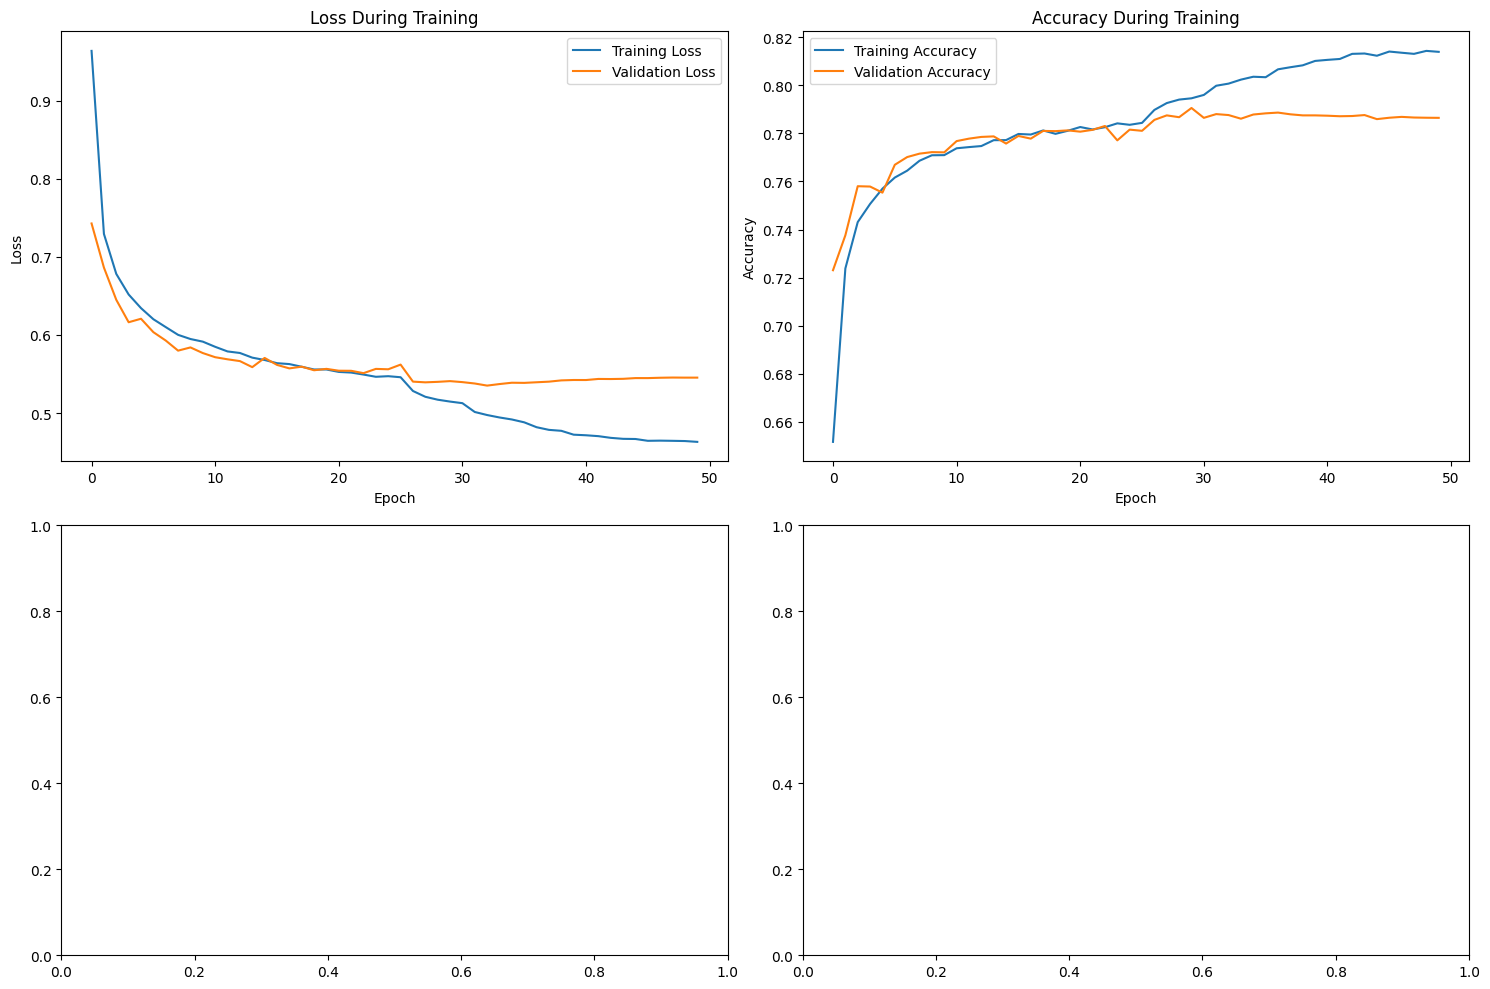

2573/2573 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step

Classification Report:
                precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00       677
      Backdoor       0.16      0.04      0.07       583
           DoS       0.30      0.03      0.05      4089
      Exploits       0.53      0.83      0.65     11132
       Fuzzers       0.32      0.46      0.37      6062
       Generic       0.99      0.97      0.98     18871
        Normal       0.92      0.80      0.85     37000
Reconnaissance       0.61      0.78      0.69      3496
     Shellcode       0.31      0.38      0.34       378
         Worms       0.17      0.05      0.07        44

      accuracy                           0.76     82332
     macro avg       0.43      0.43      0.41     82332
  weighted avg       0.78      0.76      0.76     82332



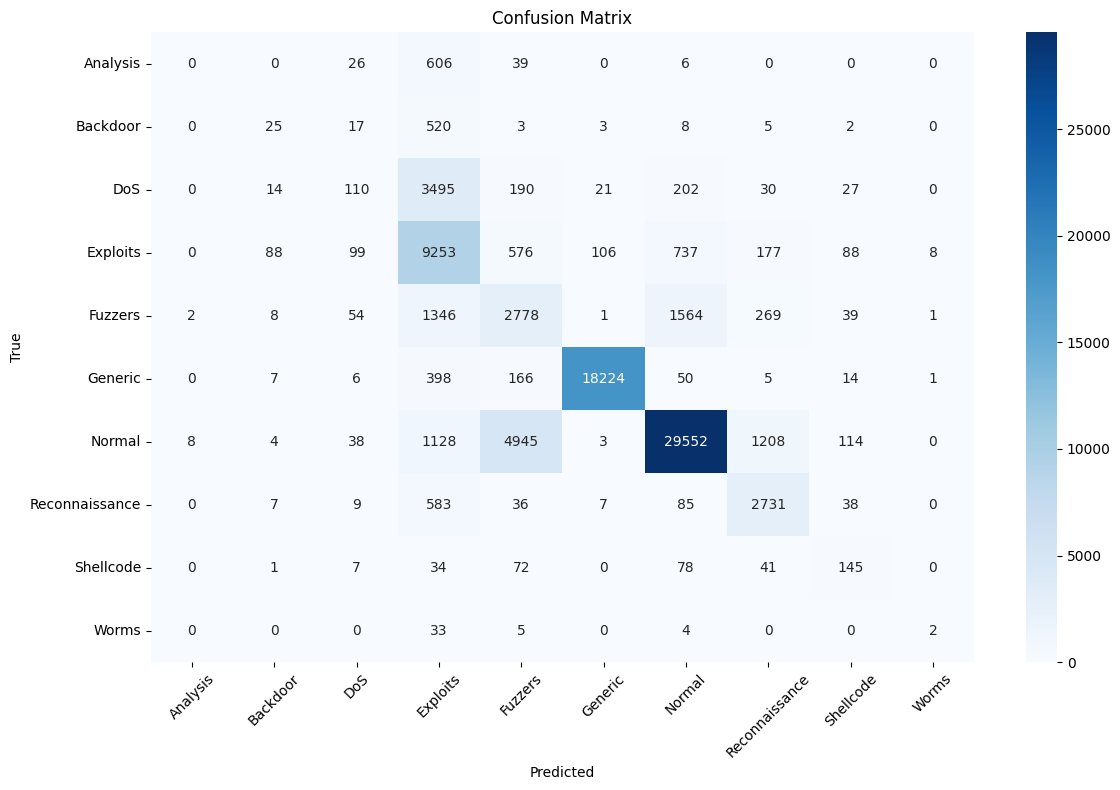

In [23]:
# Plot results
plot_training_history(history)
analyze_model_performance(model, X_test, y_test, 
                            preprocessor.label_encoder['attack_cat'].classes_)

## 8. Conclusions

The project demonstrated that deep learning models could classify network attacks effectively. Future work could involve:
- Exploring other machine learning algorithms.
- Implementing the solution in real-time systems.
- Evaluating the model on other datasets.


## 9. References

- [UNSW-NB15 Dataset](https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/)
- Notebook inspiration and preprocessing techniques were adapted from: [Soumit's Kaggle Notebook](https://www.kaggle.com/code/soumit1803063/unswnb15-preprocess)
- Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.
